## **Load Kaggle API & Download Dataset**

In [1]:
# Initialize Kaggle API
!mkdir -p ./dataset
!cp kaggle.json ./dataset
!chmod 600 ./dataset/kaggle.json
!rm kaggle.json

cp: cannot stat 'kaggle.json': No such file or directory
rm: cannot remove 'kaggle.json': No such file or directory


In [2]:
!kaggle datasets download -d irkaal/foodcom-recipes-and-reviews -p dataset

Dataset URL: https://www.kaggle.com/datasets/irkaal/foodcom-recipes-and-reviews
License(s): CC0-1.0
100% 722M/723M [00:47<00:00, 20.2MB/s]
100% 723M/723M [00:47<00:00, 15.9MB/s]


In [3]:
!unzip ./dataset/foodcom-recipes-and-reviews.zip -d ./dataset/
!rm ./dataset/foodcom-recipes-and-reviews.zip

Archive:  ./dataset/foodcom-recipes-and-reviews.zip
replace ./dataset/recipes.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


## **Import Library**

In [4]:
pip install autocorrect

In [5]:
pip install textblob pyspellchecker

In [6]:
import pandas as pd
import string
import matplotlib.pyplot as plt
import pylab
import scipy.stats as stats
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import word_tokenize
from autocorrect import Speller
from textblob import TextBlob
from spellchecker import SpellChecker

In [7]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [8]:
# Text Preprocessing
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [9]:
df=pd.read_csv('./dataset/recipes.csv')

In [10]:
df.head(2)

,RecipeId,Name,AuthorId,AuthorName,CookTime,PrepTime,TotalTime,DatePublished,Description,Images,...,SaturatedFatContent,CholesterolContent,SodiumContent,CarbohydrateContent,FiberContent,SugarContent,ProteinContent,RecipeServings,RecipeYield,RecipeInstructions
0,38,Low-Fat Berry Blue Frozen Dessert,1533,Dancer,PT24H,PT45M,PT24H45M,1999-08-09T21:46:00Z,Make and share this Low-Fat Berry Blue Frozen ...,"c(""https://img.sndimg.com/food/image/upload/w_...",...,1.3,8.0,29.8,37.1,3.6,30.2,3.2,4.0,NaN,"c(""Toss 2 cups berries with sugar."", ""Let stan..."
1,39,Biryani,1567,elly9812,PT25M,PT4H,PT4H25M,1999-08-29T13:12:00Z,Make and share this Biryani recipe from Food.com.,"c(""https://img.sndimg.com/food/image/upload/w_...",...,16.6,372.8,368.4,84.4,9.0,20.4,63.4,6.0,NaN,"c(""Soak saffron in warm milk for 5 minutes and..."


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 522517 entries, 0 to 522516
Data columns (total 28 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   RecipeId                    522517 non-null  int64  
 1   Name                        522517 non-null  object 
 2   AuthorId                    522517 non-null  int64  
 3   AuthorName                  522517 non-null  object 
 4   CookTime                    439972 non-null  object 
 5   PrepTime                    522517 non-null  object 
 6   TotalTime                   522517 non-null  object 
 7   DatePublished               522517 non-null  object 
 8   Description                 522512 non-null  object 
 9   Images                      522516 non-null  object 
 10  RecipeCategory              521766 non-null  object 
 11  Keywords                    505280 non-null  object 
 12  RecipeIngredientQuantities  522514 non-null  object 
 13  RecipeIngredie

## **Data Visualization**

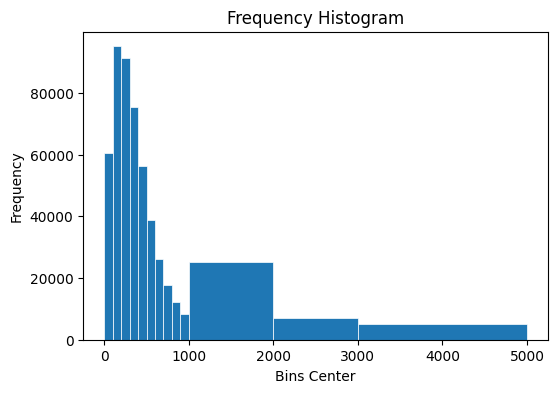

In [12]:
fig, ax = plt.subplots(figsize=(6, 4))
plt.title('Frequency Histogram')
plt.ylabel('Frequency')
plt.xlabel('Bins Center')
ax.hist(df.Calories.to_numpy(),bins=[0,100,200,300,400,500,600,700,800,900,1000,2000,3000,5000],linewidth=0.5, edgecolor="white")
plt.show()

**Summary:** The histogram provides a visual representation of the distribution of calorie values in the dataset. This helps in understanding how calories are spread across different recipes.

**Insight:** The histogram indicates that most recipes have calories within the lower range (0-1000 calories), with significantly fewer recipes having higher calorie counts.

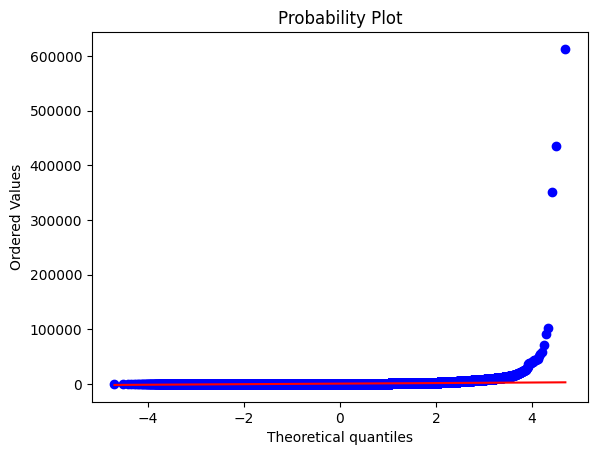

In [13]:
stats.probplot(df.Calories.to_numpy(), dist="norm", plot=pylab)
pylab.show()

**Summary:**
*   The majority of the recipes have calories in the lower range (0-1000 calories)
*   The data is highly skewed towards the lower calorie range, indicating that most recipes are under 1000 in calories.
*   There are several extreme values (outliers) in the higher calorie range, as indicated by the points far from the line.

**Insights:**
*   There is some outlier in calories (too high)

## **Data Preparation**

### Select Relevant Column for Building RecSys

In [14]:
columns=['RecipeId','Name','CookTime','PrepTime','TotalTime','RecipeIngredientParts','Calories','FatContent','SaturatedFatContent','CholesterolContent','SodiumContent','CarbohydrateContent','FiberContent','SugarContent','ProteinContent','RecipeInstructions']
df=df[columns]

### Filter Recipe to Follow this Max Nutritient

In [15]:
# https://www.dietaryguidelines.gov/
max_Calories=1000

# https://www.ncbi.nlm.nih.gov/books/NBK56068/
max_daily_fat=100

# https://www.heart.org/
max_daily_Saturatedfat=13

# https://www.dietaryguidelines.gov/
max_daily_Cholesterol=300

# https://www.ncbi.nlm.nih.gov/books/NBK56068/
max_daily_Sodium=2300

# https://www.ncbi.nlm.nih.gov/books/NBK56068/
max_daily_Carbohydrate=325

# https://www.ncbi.nlm.nih.gov/books/NBK56068/
max_daily_Fiber=40

# https://www.heart.org/
max_daily_Sugar=40

# https://www.ncbi.nlm.nih.gov/books/NBK56068/
max_daily_Protein=200

max_list=[max_Calories,max_daily_fat,max_daily_Saturatedfat,max_daily_Cholesterol,max_daily_Sodium,max_daily_Carbohydrate,max_daily_Fiber,max_daily_Sugar,max_daily_Protein]

In [16]:
# from index 6 to 14 which contain nutritional value with the corresponding maximum value in max_list
for column,maximum in zip(df.columns[6:15],max_list):
    df=df[df[column]<maximum]

In [17]:
df.head(2)

,RecipeId,Name,CookTime,PrepTime,TotalTime,RecipeIngredientParts,Calories,FatContent,SaturatedFatContent,CholesterolContent,SodiumContent,CarbohydrateContent,FiberContent,SugarContent,ProteinContent,RecipeInstructions
0,38,Low-Fat Berry Blue Frozen Dessert,PT24H,PT45M,PT24H45M,"c(""blueberries"", ""granulated sugar"", ""vanilla ...",170.9,2.5,1.3,8.0,29.8,37.1,3.6,30.2,3.2,"c(""Toss 2 cups berries with sugar."", ""Let stan..."
3,41,Carina's Tofu-Vegetable Kebabs,PT20M,PT24H,PT24H20M,"c(""extra firm tofu"", ""eggplant"", ""zucchini"", ""...",536.1,24.0,3.8,0.0,1558.6,64.2,17.3,32.1,29.3,"c(""Drain the tofu, carefully squeezing out exc..."


In [18]:
# DropNaN, Reset Index, Drop Duplicates
df = df.dropna()
df = df.reset_index(drop=True)
df = df.drop_duplicates(subset='Name', keep='first')
df = df.drop_duplicates(subset='RecipeIngredientParts', keep='first')
df = df.drop_duplicates(subset='RecipeInstructions', keep='first')

In [19]:
df.isnull().sum()

RecipeId                 0
Name                     0
CookTime                 0
PrepTime                 0
TotalTime                0
RecipeIngredientParts    0
Calories                 0
FatContent               0
SaturatedFatContent      0
CholesterolContent       0
SodiumContent            0
CarbohydrateContent      0
FiberContent             0
SugarContent             0
ProteinContent           0
RecipeInstructions       0
dtype: int64

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 261445 entries, 0 to 312110
Data columns (total 16 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   RecipeId               261445 non-null  int64  
 1   Name                   261445 non-null  object 
 2   CookTime               261445 non-null  object 
 3   PrepTime               261445 non-null  object 
 4   TotalTime              261445 non-null  object 
 5   RecipeIngredientParts  261445 non-null  object 
 6   Calories               261445 non-null  float64
 7   FatContent             261445 non-null  float64
 8   SaturatedFatContent    261445 non-null  float64
 9   CholesterolContent     261445 non-null  float64
 10  SodiumContent          261445 non-null  float64
 11  CarbohydrateContent    261445 non-null  float64
 12  FiberContent           261445 non-null  float64
 13  SugarContent           261445 non-null  float64
 14  ProteinContent         261445 non-null  f

## **Data Pre-Processing**

In [21]:
# Define column for pre-processing
columns=['Name', 'RecipeIngredientParts','RecipeInstructions']
df_preprocessing=df[columns]
df_preprocessing.head(2)

,Name,RecipeIngredientParts,RecipeInstructions
0,Low-Fat Berry Blue Frozen Dessert,"c(""blueberries"", ""granulated sugar"", ""vanilla ...","c(""Toss 2 cups berries with sugar."", ""Let stan..."
1,Carina's Tofu-Vegetable Kebabs,"c(""extra firm tofu"", ""eggplant"", ""zucchini"", ""...","c(""Drain the tofu, carefully squeezing out exc..."


### Data Cleaning


In [22]:
# Before
df_preprocessing['RecipeIngredientParts'][0]

'c("blueberries", "granulated sugar", "vanilla yogurt", "lemon juice")'

In [23]:
# Before
df_preprocessing['RecipeInstructions'][0]

'c("Toss 2 cups berries with sugar.", "Let stand for 45 minutes, stirring occasionally.", "Transfer berry-sugar mixture to food processor.", "Add yogurt and process until smooth.", "Strain through fine sieve. Pour into baking pan (or transfer to ice cream maker and process according to manufacturers\' directions). Freeze uncovered until edges are solid but centre is soft.  Transfer to processor and blend until smooth again.", "Return to pan and freeze until edges are solid.", "Transfer to processor and blend until smooth again.", \n"Fold in remaining 2 cups of blueberries.", "Pour into plastic mold and freeze overnight. Let soften slightly to serve.")'

In [24]:
df_preprocessing['Name'][0]

'Low-Fat Berry Blue Frozen Dessert'

In [25]:
df_cleaning=df_preprocessing.copy()

In [26]:
def cleaning(text):
    text = re.sub(r"[c\(\)\"]", "", str(text))
    return text

In [27]:
df_cleaning['NameClean'] = df_cleaning['Name'].apply(cleaning)
df_cleaning['RecipeIngredientPartsClean'] = df_cleaning['RecipeIngredientParts'].str.replace(r"[c\(\)\"]", "", regex=True) # Removing unwanted characters
df_cleaning['RecipeInstructionsClean'] = df_cleaning['RecipeInstructions'].str.replace(r"[c\(\)\"]", "", regex=True).str.replace('\n', '', regex=False)  # Removing unwanted characters

In [28]:
# After
df_cleaning['NameClean'][0]

'Low-Fat Berry Blue Frozen Dessert'

In [29]:
# After
df_cleaning['RecipeIngredientPartsClean'][0]

'blueberries, granulated sugar, vanilla yogurt, lemon juie'

In [30]:
# After
df_cleaning['RecipeInstructionsClean'][0]

"Toss 2 ups berries with sugar., Let stand for 45 minutes, stirring oasionally., Transfer berry-sugar mixture to food proessor., Add yogurt and proess until smooth., Strain through fine sieve. Pour into baking pan or transfer to ie ream maker and proess aording to manufaturers' diretions. Freeze unovered until edges are solid but entre is soft.  Transfer to proessor and blend until smooth again., Return to pan and freeze until edges are solid., Transfer to proessor and blend until smooth again., Fold in remaining 2 ups of blueberries., Pour into plasti mold and freeze overnight. Let soften slightly to serve."

### Text Preprocessing (Remove Space, Case Folding) in RecipeIngredientParts & RecipeInstructions

In [31]:
def remove_space_case_folding(ingredients):
    ingredients = re.sub(r'[^a-zA-Z0-9\s]', '', ingredients)
    ingredients = ingredients.lower() # Case folding
    return ingredients

In [32]:
df_casefolding=df_cleaning.copy()

In [33]:
# Before
df_cleaning['RecipeIngredientPartsClean'][0]

'blueberries, granulated sugar, vanilla yogurt, lemon juie'

In [34]:
df_cleaning['RecipeIngredientPartsClean'][0]

'blueberries, granulated sugar, vanilla yogurt, lemon juie'

In [35]:
df_cleaning['NameClean'][0]

'Low-Fat Berry Blue Frozen Dessert'

In [36]:
df_casefolding['RecipeIngredientPartsClean'] = df_casefolding['RecipeIngredientPartsClean'].apply(remove_space_case_folding)

In [37]:
df_casefolding['RecipeInstructionsClean'] = df_casefolding['RecipeInstructionsClean'].apply(remove_space_case_folding)

In [38]:
df_casefolding['NameClean'] = df_casefolding['NameClean'].apply(remove_space_case_folding)

In [39]:
# After
df_casefolding['RecipeIngredientPartsClean'][0]

'blueberries granulated sugar vanilla yogurt lemon juie'

In [40]:
#After
df_casefolding['RecipeInstructionsClean'][0]

'toss 2 ups berries with sugar let stand for 45 minutes stirring oasionally transfer berrysugar mixture to food proessor add yogurt and proess until smooth strain through fine sieve pour into baking pan or transfer to ie ream maker and proess aording to manufaturers diretions freeze unovered until edges are solid but entre is soft  transfer to proessor and blend until smooth again return to pan and freeze until edges are solid transfer to proessor and blend until smooth again fold in remaining 2 ups of blueberries pour into plasti mold and freeze overnight let soften slightly to serve'

In [41]:
# After
df_casefolding['NameClean'][0]

'lowfat berry blue frozen dessert'

### Lemmatization

In [42]:
def lemmatization(ingredients):
  words = ingredients.split()
  lemmatized_words = [lemmatizer.lemmatize(word) for word in words if word.lower() not in stop_words]
  return ' '.join(lemmatized_words)

In [43]:
df_lemmatization=df_casefolding.copy()

In [44]:
# Before
df_casefolding['RecipeIngredientPartsClean'][0]

'blueberries granulated sugar vanilla yogurt lemon juie'

In [45]:
# Before
df_casefolding['RecipeInstructionsClean'][0]

'toss 2 ups berries with sugar let stand for 45 minutes stirring oasionally transfer berrysugar mixture to food proessor add yogurt and proess until smooth strain through fine sieve pour into baking pan or transfer to ie ream maker and proess aording to manufaturers diretions freeze unovered until edges are solid but entre is soft  transfer to proessor and blend until smooth again return to pan and freeze until edges are solid transfer to proessor and blend until smooth again fold in remaining 2 ups of blueberries pour into plasti mold and freeze overnight let soften slightly to serve'

In [46]:
df_lemmatization['RecipeIngredientPartsClean'] = df_lemmatization['RecipeIngredientPartsClean'].apply(lemmatization)

In [47]:
df_lemmatization['RecipeInstructionsClean'] = df_lemmatization['RecipeInstructionsClean'].apply(lemmatization)

In [48]:
# After
df_lemmatization['RecipeIngredientPartsClean'][0]

'blueberry granulated sugar vanilla yogurt lemon juie'

In [49]:
df_lemmatization['RecipeInstructionsClean'][0]

'toss 2 ups berry sugar let stand 45 minute stirring oasionally transfer berrysugar mixture food proessor add yogurt proess smooth strain fine sieve pour baking pan transfer ie ream maker proess aording manufaturers diretions freeze unovered edge solid entre soft transfer proessor blend smooth return pan freeze edge solid transfer proessor blend smooth fold remaining 2 ups blueberry pour plasti mold freeze overnight let soften slightly serve'

### Tokennizer

In [50]:
def tokenize_sentence(text):
    tokens = word_tokenize(text)  # Tokenize the input string
    return ' '.join(tokens)  # Join the tokens back into a single string

In [51]:
df_tokenization=df_lemmatization.copy()

In [52]:
# Before
df_lemmatization['RecipeIngredientPartsClean'][0]

'blueberry granulated sugar vanilla yogurt lemon juie'

In [53]:
# Before
df_lemmatization['NameClean'][0]

'lowfat berry blue frozen dessert'

In [54]:
df_tokenization['RecipeIngredientPartsToken'] = df_tokenization['RecipeIngredientPartsClean'].apply(tokenize_sentence)

In [55]:
df_tokenization['NameToken'] = df_tokenization['NameClean'].apply(tokenize_sentence)

In [56]:
# After
df_tokenization['RecipeIngredientPartsToken'][0]

'blueberry granulated sugar vanilla yogurt lemon juie'

In [57]:
# After
df_tokenization['NameToken'][0]

'lowfat berry blue frozen dessert'

### Combined

In [58]:
df_tokenization['Combined'] = df_tokenization['RecipeIngredientPartsToken'] + df_tokenization['NameToken'] + df_tokenization['RecipeInstructionsClean']
df_tokenization.head(2)

,Name,RecipeIngredientParts,RecipeInstructions,NameClean,RecipeIngredientPartsClean,RecipeInstructionsClean,RecipeIngredientPartsToken,NameToken,Combined
0,Low-Fat Berry Blue Frozen Dessert,"c(""blueberries"", ""granulated sugar"", ""vanilla ...","c(""Toss 2 cups berries with sugar."", ""Let stan...",lowfat berry blue frozen dessert,blueberry granulated sugar vanilla yogurt lemo...,toss 2 ups berry sugar let stand 45 minute sti...,blueberry granulated sugar vanilla yogurt lemo...,lowfat berry blue frozen dessert,blueberry granulated sugar vanilla yogurt lemo...
1,Carina's Tofu-Vegetable Kebabs,"c(""extra firm tofu"", ""eggplant"", ""zucchini"", ""...","c(""Drain the tofu, carefully squeezing out exc...",carinas tofuvegetable kebabs,extra firm tofu eggplant zuhini mushroom soy s...,drain tofu arefully squeezing ex water pat dry...,extra firm tofu eggplant zuhini mushroom soy s...,carinas tofuvegetable kebabs,extra firm tofu eggplant zuhini mushroom soy s...


In [59]:
df_combined = df.drop(columns=['Name', 'RecipeIngredientParts','RecipeInstructions']).join(df_tokenization)
df_combined = df_combined.drop(columns=['RecipeIngredientParts', 'RecipeInstructions', 'Name', 'NameToken', 'RecipeIngredientPartsToken', 'CookTime', 'PrepTime', 'TotalTime'])

In [60]:
df_combined.head(1)

,RecipeId,Calories,FatContent,SaturatedFatContent,CholesterolContent,SodiumContent,CarbohydrateContent,FiberContent,SugarContent,ProteinContent,NameClean,RecipeIngredientPartsClean,RecipeInstructionsClean,Combined
0,38,170.9,2.5,1.3,8.0,29.8,37.1,3.6,30.2,3.2,lowfat berry blue frozen dessert,blueberry granulated sugar vanilla yogurt lemo...,toss 2 ups berry sugar let stand 45 minute sti...,blueberry granulated sugar vanilla yogurt lemo...


## **Export Cleaned Data**

In [61]:
df_combined.to_csv('./dataset/preprocessed_recipes.csv', index=False)